# Data Science Project for a real estate Company

Alankrita Pathak

## Problem Statement

We have a dataset, containing the following fields:

- *listing_id*: unique identifier for a listing
- *zip_code*: postal code in which the listing is located
- *list_date*: date on which the listing went live on the market
- *resale_close_date*: date on which the listing was sold
- *price_valuation*: our best view of the home's value at time of list
- *price_listing_original*: the price at which the home was originally listed
- *price_listing_last*: the last list price of the home prior to resale
- *price_resale*: the price at which the home was resold to a buyer

Prompt:

Using the data provided, suggest a simple model that leverages the home valuation to generate an original list price for a given home that will maximize profit for a seller.

Create a short proposal for your suggested model along with any exploritory analysis, data viz, regrission output, etc. that informed your suggestion.

## Preparing the dataset

### Import libraries and configuration

In [1]:
# Load the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from math import sqrt


# Plotting options
%matplotlib inline

### Load and Preprocessing data

In [2]:
# Read the data
housing_df = pd.read_csv("listings.csv")

# Convert dates to date-time format
housing_df['list_date'] = pd.to_datetime(housing_df['list_date'])
housing_df['resale_close_date']=pd.to_datetime(housing_df['resale_close_date'])


# Filter out listings with missing data.

invalid_price_condition = housing_df.price_listing_original.isnull() | (housing_df.price_listing_original==0) | housing_df.price_listing_last.isnull() | (housing_df.price_listing_last==0) | housing_df.price_valuation.isnull() | (housing_df.price_valuation==0)
percent_listings_invalid = len(housing_df[invalid_price_condition]) / len(housing_df) * 100
print("percentage of listings with invalid pricing: " + str(percent_listings_invalid) + "%")
housing_df = housing_df[~invalid_price_condition]

housing_df.head()

percentage of listings with invalid pricing: 2.2148394241417497%


,listing_id,zip_code,list_date,resale_close_date,price_valuation,price_listing_original,price_listing_last,price_resale
0,1,85087,2016-09-14,2016-10-31,277835.58,269280.0,261360.0,229388.94
1,2,85042,2016-05-05,2016-06-23,221704.56,220770.0,220770.0,220770.00
2,3,75068,2016-09-20,2017-01-25,284164.51,355520.0,330270.0,330270.00
3,4,85143,2016-08-22,2016-11-14,169247.43,172260.0,168300.0,165330.00
4,5,85326,2016-09-11,2017-01-18,183335.20,203010.0,198970.0,191900.00


Only 2.21% of the 1806 listings have empty or invalid price, so we can filter out these rows without losing significant data for analysis.

## Exploratory Analysis

Doing exploratory analysis on 3 types of data to identify correlations

- Geographical Analysis
- Temporal Analysis
- Pricing Analysis

### Geographical Analysis

Number of unique zip codes: 251
Histogram of zip codes:


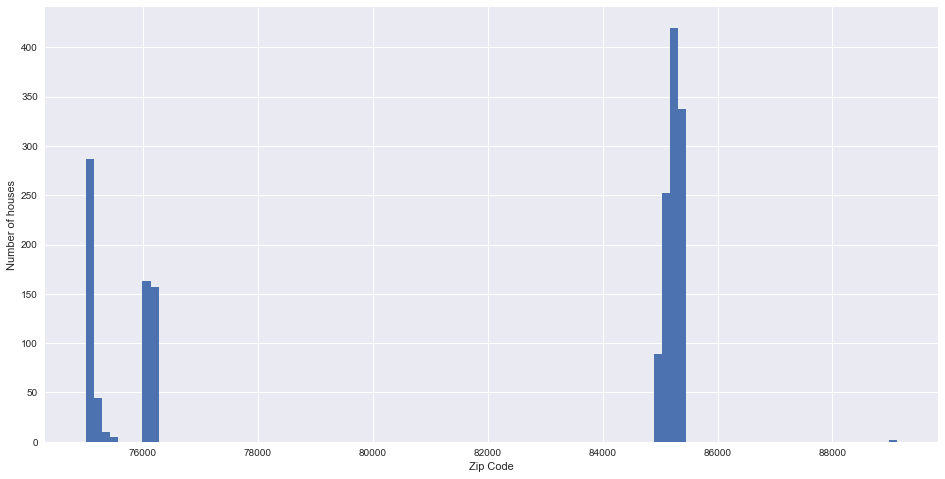

In [3]:
# Zip Code histogram

print("Number of unique zip codes: " + str(len(housing_df.zip_code.unique())))

print("Histogram of zip codes:")
graph = housing_df.zip_code.hist(bins=100, figsize=(16,8))
graph.set_xlabel("Zip Code")
graph.set_ylabel("Number of houses")

Houses are spread out over a lot of different ZIP Codes without being concentrated in a handful of zip codes. Thus we can effectively leverage ZIP Code data into our prediction analysis.

### Temporal Analysis

In [4]:
# Range of list_date
print("Oldest list date: " + str(housing_df.list_date.min()))
print("Newest list date: " + str(housing_df.list_date.max()))

Oldest list date: 2016-01-04 00:00:00
Newest list date: 2016-12-31 00:00:00


The date range is "2016-01-04" to "2016-12-31". Since, the data is only for the year 2016, we don't have to acccount for the housing bouble or other historical incidents.

Mean listing lifespan: 95.6013590033975 days
Median listing lifespan: 82.0 days
Histogram of listing lifespan in days


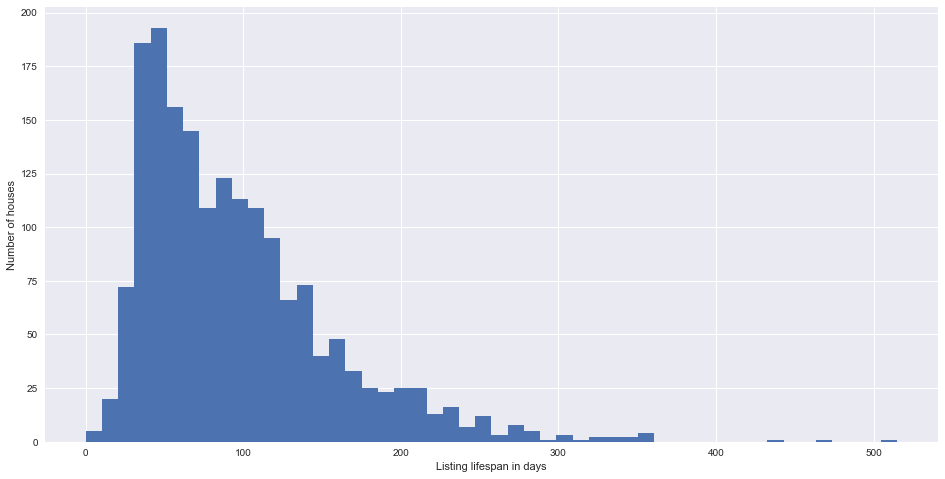

In [5]:
# Number of days a listing stays online before being sold
housing_df['listing_lifespan_days'] = (housing_df.resale_close_date - housing_df.list_date).dt.days
graph = housing_df['listing_lifespan_days'].hist(bins=50, figsize=(16,8))
graph.set_xlabel("Listing lifespan in days")
graph.set_ylabel("Number of houses")

print("Mean listing lifespan: " + str(housing_df['listing_lifespan_days'].mean()) + " days")
print("Median listing lifespan: " + str(housing_df['listing_lifespan_days'].median()) + " days")

print("Histogram of listing lifespan in days")

Above analysis on the dates shows that on an average , it takes around 3 months to sell a house. Next we will analyze if there are any monthly patterns in the sale of houses.

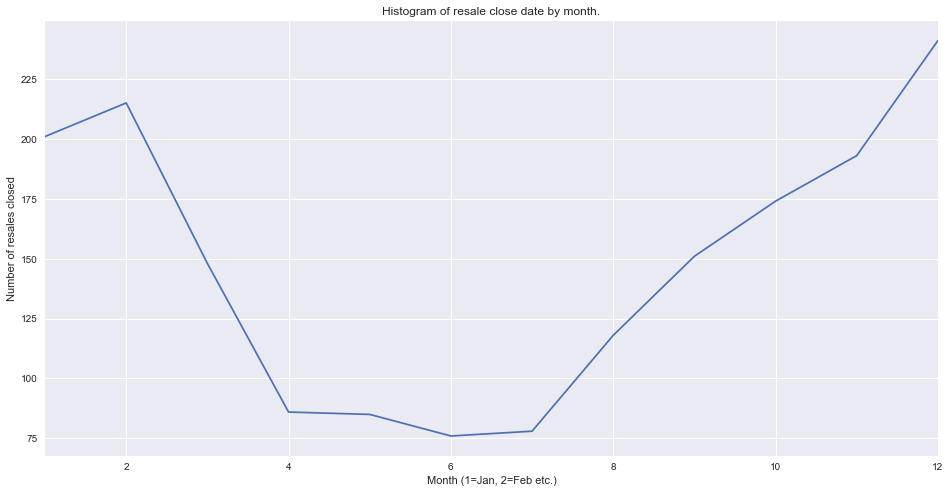

In [6]:
# Histogram of "resale close date" by month.
graph = housing_df.resale_close_date.dt.month.value_counts().sort_index().plot(figsize=(16,8),
                                                                       title="Histogram of resale close date by month.")

graph.set_xlabel('Month (1=Jan, 2=Feb etc.)')
graph.set_ylabel('Number of resales closed')

This shows that housing sales are low from April-Aug and keep increasing after that.

Since the mean listing length is around 3 months, doing a fine-grained analysis by day of week would not add much value. Our model can leverage "sales by month" information to recommend a price based on market trend at the time of listing.

### Pricing Analysis

Before we analyze pricing, we define the following 2 terms:

#### Profit percentage

Assuming that the true value of the house is based on the "price valuation". Thus, the profit would be based on the difference between selling price and price valuation. Mathematically,

*profit % = (resale price - price valuation) / (price valuation) &ast; 100*

#### Markup multiplier

The seller would set the list price by multiplying the "price valuation" with a constant ratio. We define this ratio of list price to the price valuation as mark-up multiplier. Mathematically,

*markup multiplier = (list price) / (price valuation)*

#### Price drop percentage

If the listing stays on for few days, the seller reduces the listed price. Let's call the percentage by which this goes down as the price drop percentage. Mathematically,

*price drop % = (original list price - final list price) / (original list price) &ast; 100*


In [7]:
housing_df['profit_percentage'] = ((housing_df.price_resale - housing_df.price_valuation)/housing_df.price_valuation) * 100
housing_df['markup_multiplier'] = housing_df.price_listing_original/housing_df.price_valuation
housing_df['price_drop_percentage'] = (housing_df.price_listing_original - housing_df.price_listing_last)/housing_df.price_listing_original * 100

Histogram of price valuation


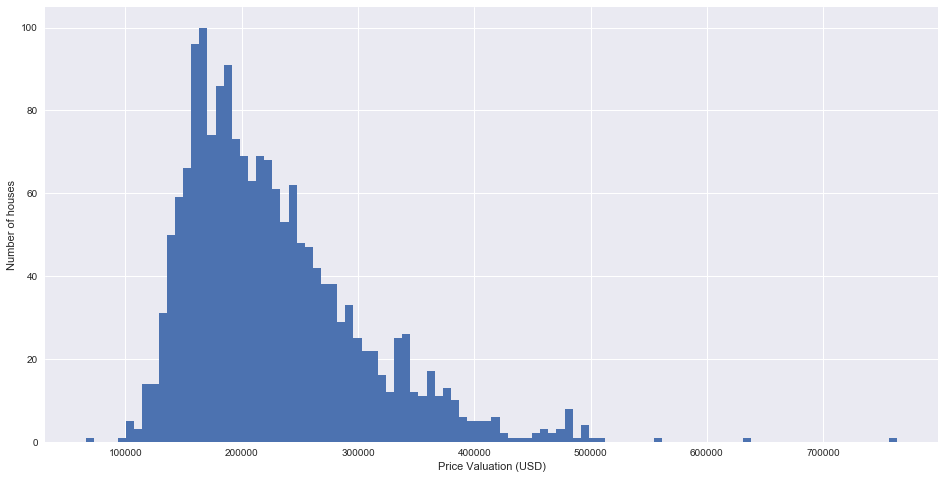

In [8]:
# Distribution of price valuation

print("Histogram of price valuation")
graph = housing_df.price_valuation.hist(bins=100, figsize=(16,8))
graph.set_xlabel("Price Valuation (USD)")
graph.set_ylabel("Number of houses")

If a listing stays too long on the website, the seller might start offering discounts on the list price. Plotting the price drop v/s listing lifespan to see if there's any correlation between them.

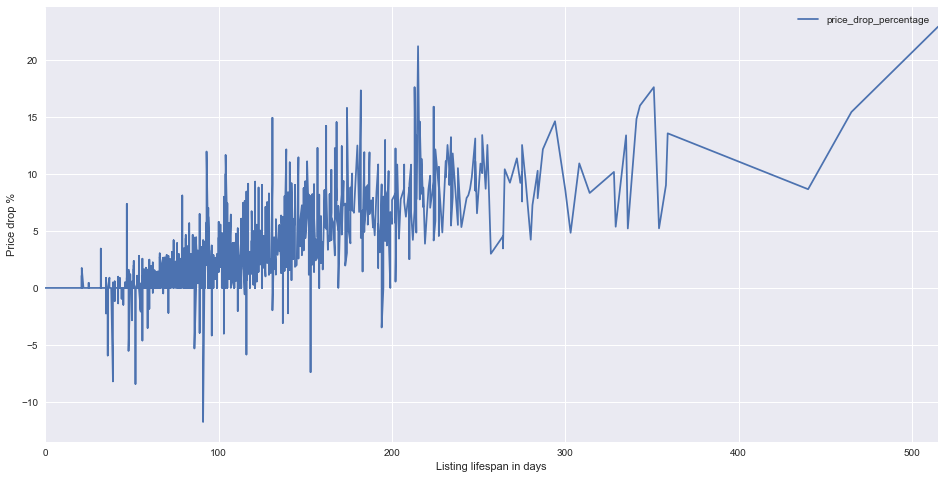

In [9]:
# Price drop v/s listing lifespan
graph = housing_df.sort_values('listing_lifespan_days').plot(x='listing_lifespan_days', y='price_drop_percentage', figsize=(16,8))

graph.set_xlabel("Listing lifespan in days")
graph.set_ylabel("Price drop %")

The above analysis shows that the amount of discount given increses as listing lifespan increases, which is in agreement with the intuition above.

If the Markup multiplier is high, chances are high that the house will sell at a higher price, thus making a higher profit. To check how these correlate, we plot the markup v/s profit.

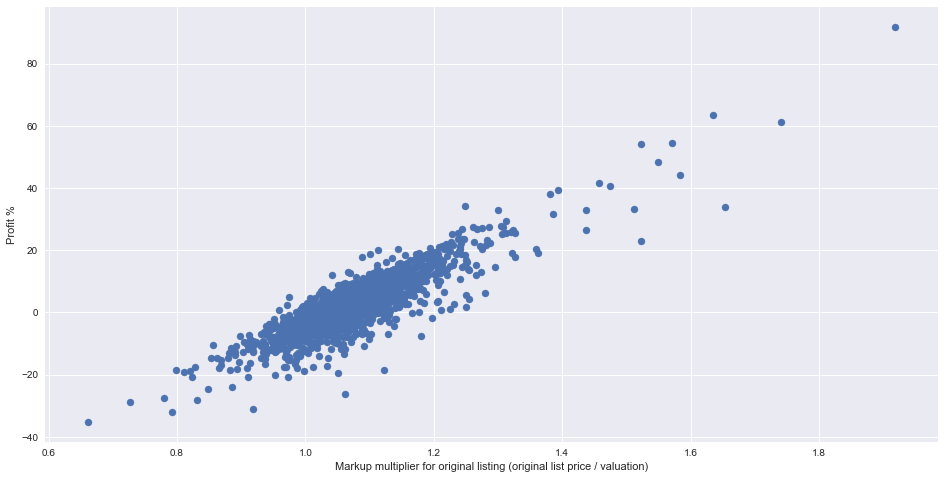

In [10]:
graph = housing_df.plot(kind = 'scatter', x = 'markup_multiplier', y = 'profit_percentage', s = 50, figsize=(16,8))
graph.set_xlabel("Markup multiplier for original listing (original list price / valuation)")
graph.set_ylabel("Profit %")

Above graph shows a very strong positive correlation between markup and profit.

This means,

- Higher markup results in higher profit
- As the seller keeps increasing the markup, the seller should keep earning higher profits.

Just based on this information, seller should be able to make infinite profit, but we know intuitively this isn't true.

We know that,

- **Increasing listing price beyond a certain limit will make the buyer not make the purchase at all**

Our data does not show this, as our data is for houses that were **sold**.

We need to keep this along with other inferences from the exploratory analysis in mind, while recommending the original list price.

Inflated_ratio = .price_listing_original/price_valuation
Above graph shows that
- More inflation results in more profit
- ButIncreasing listing  price beyond a certain limit  can increse the profit but it can decrease the sales as over pricing impact the customer's willingness to pay and it can also benefit the competitors in the market and this is not visible in the above graph as the data is only for the houses that eventually got sold.


## Prediction

Our goal is to predict model that leverages the home valuation to generate an original list price for a given home that will maximize profit for a seller.

We know we cannot keep increasing the listing price as buyer-seller situation is a case of [Non-cooperative game theory](https://en.wikipedia.org/wiki/Non-cooperative_game_theory).

- The seller wants to keep increasing the price
- The buyer wants to keep reducing the price

However, if both seller and buyer have it their way, there would be no transaction. So, for making the highest profit for seller, we want the following

- The seller to sell at the highest price AND buyer to buy the house. ie. transaction should happen.

Since we do not have data for prices at which the buyer would NOT buy the house, we make the following 2 assumptions for solving the [nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium) at a price where the seller is able to sell the house while earning the max profit.

1. The actual sell price is the maximum, a buyer is ready to pay
2. The actual **last** listed price is the price at which the buyer actually comes in to negotiate a purchase.

This reduces the original problem statement to predicting the actual **last listing price** given the zip code, listing date, price valuation and other metadata.

Note:

1. The last listing price, we model this way can be used as the original listing price. According to our model, the house should be sold without having to reduce the listing price.
2. We do not directly model the sale price, to incorporate the fact that buyers expect negotiation on the listed price in the real-estate market. We assume that the last listed price is the maximum price at which, the buyer would be willing to negotiate and make a purchase. 

When we have a new house, for which we want to set the listing price, we do not have the data for it's actual sell price and resale close date, so we cannot use these as features for our models, as doing that would mean we are using data from future to predict something in past.

### Normalization

Since the [distribution of house prices](#Pricing-Analysis) is very broad and consists of much higher numbers (magnitude-wise), we have to normalize the house prices.

Normalizing the data by subtracting mean of valuation from all house prices (valuation, selling price, original list price, final list price). We can use the same mean to normalize all the pricing colums as selling price, original list price and final list price can be assumed to be derived from the valuation with some markup/markdown.

In [11]:
# Calculate mean of house valuation

mean_valuation = housing_df.price_valuation.mean()

housing_df['price_valuation'] = housing_df.price_valuation - mean_valuation
housing_df['price_listing_original'] = housing_df.price_listing_original - mean_valuation
housing_df['price_listing_last'] = housing_df.price_listing_last - mean_valuation
housing_df['price_resale'] = housing_df.price_resale - mean_valuation

### Regression

We will use Linear Regression as the feature set is small. More sophisticated/complex models could overfit data.

In [12]:
# Algorithm:
#
# 1) Use {zip code, valuation, listing month} to predict -> {resale price}.
# 2) Use {zip code, valuation, listing month, resale price} to predict {final list price}.
# 3) Use the predicted final list price as the original list price for posting the house.
def housing_price_predictor(model):
    
    ## Step 1)

    # Build the feature vector
    X = housing_df[['zip_code', 'price_valuation']]
    X['list_month'] = housing_df['list_date'].dt.month
    X.head()

    # Build the labels
    Y = housing_df['price_resale']

    # Train/test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

    # Fit the model
    weights = model.fit(X_train, Y_train)
    
    # Compute predicted values
    predicted_price_resale = model.predict(X)
    predicted_price_resale_test = model.predict(X_test)
    
    # calculate RMSE normalized by mean valuation
    RMSE_normalized = (sqrt(mean_squared_error(Y_test, predicted_price_resale_test))) / mean_valuation

    # print accuracy and RMSE
    print("Step 1 Model Score: " + str(model.score(X_test,Y_test)))
    print("step 1 RMSE normalized by mean valuation: " + str(RMSE_normalized))


    
    ## Step 2

    # Build the feature vector
    
    X['predicted_price_resale'] = predicted_price_resale

    # Buld the labels
    Y = housing_df['price_listing_last']

    # Train/test split.
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

    # Fit the model
    weights = model.fit(X_train,Y_train)

    # Compute predicted values
    predicted_list_price = model.predict(X_test)
    
    # Calculate RMSE and normalize it with mean_valuation
    RMSE_normalized = (sqrt(mean_squared_error(Y_test,predicted_list_price)))/mean_valuation
    
    # Print accuracy and RMSE
    print("Step 2 Model score: " + str(model.score(X_test,Y_test)))
    print("Step 2 RMSE normaized by mean valuation: " + str(RMSE_normalized))

    

### Results

In [13]:
print("Using Linear Regression:")
housing_price_predictor(linear_model.LinearRegression())

print()

print("Using Ridge Regression:")
housing_price_predictor(linear_model.Ridge())

Using Linear Regression:
Step 1 Model Score: 0.917433773753
step 1 RMSE normalized by mean valuation: 0.07189571222762271
Step 2 Model score: 0.92573598149
Step 2 RMSE normaized by mean valuation: 0.07057073300157388

Using Ridge Regression:


/Users/alankritapathak/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/alankritapathak/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Step 1 Model Score: 0.917433798876
step 1 RMSE normalized by mean valuation: 0.07189570128955282
Step 2 Model score: 0.925735981492
Step 2 RMSE normaized by mean valuation: 0.07057073300048461


#### Normalized RMSE
RMSE of a model measure the magnitude of the residuals, but it cannot be used to compare with other models in a meaningful way to determine which model provides better predictions. Taking the ratio between RMSE and mean price valuation makes the results dimensionlesas and invariant to scale, and thus normalized RMSE of a model can be used to compare performance v/s other models.

#### Conclusion
We observe that both linear and ridge regression give us comparable performance on the dataset. Since both of these are linear models, they have similar upper-bound on performance. More sophisticated models like SVMs with non-linear kernels and tree based methods can be used to model non-linearities in the data for potentially better results.

## Future work

### Improving prediction
Exploring other simple models like Random Forest and Gradient Boosting. The advantage with these tree-based methods is that they are scale invariant, so we do not have to normalize data for those. But given the size of our dataset and the number of features, there is a very high chance of overfitting. We can use cross-validation to ensure we are not overfitting.

### Better measures of performance
To know how well we did the regression, we can compare the performance against baselines. As an example, We could use average markup per zip code prediction model to validate how the proposed model does against such simple model.